## Create Data files of gph and pvu anomalies (NORMALIZED) preceding temperature. 

I am keeping ALL events. Not separating. 

In [1]:
#relevant import statements
import numpy as np
import xarray as xr 
import pickle 

/knight/anaconda_jan21/envs/aug21/lib/python3.8/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
##import 
infile = open("../GPH_reduced/gph500_NAO25deg.p", 'rb') 
gph = pickle.load(infile)
infile.close()

infile = open("../processing_ellipse/pv/pvu100_25deg.p", 'rb') 
pvu = pickle.load(infile)
infile.close()

# weighted, temperature at 1000hPa over the area in europe
infile = open("../eur1000_temp.p", 'rb') 
temp = pickle.load(infile)
infile.close()

infile = open("../processing_ellipse/data/NAO_gph500.p", 'rb') 
gph_red = pickle.load(infile)
infile.close()

In [3]:
gph.shape

(63, 152, 21, 37)

In [4]:
pvu.shape

(63, 181, 11, 145)

In [5]:
temp.shape

(63, 152)

In [6]:
gph_red.shape

(63, 151)

In [7]:
##remove leap days now
gph = np.delete(gph,[120],1)
temp = np.delete(temp,[120],1)

In [8]:
## check all for NaNs
if np.any(np.isnan(gph)) or np.any(np.isinf(gph)):
    print("NaN or Inf values found in gph!")

## check all for NaNs
if np.any(np.isnan(pvu)) or np.any(np.isinf(pvu)):
    print("NaN or Inf values found in pvu!")

In [9]:
##calculate daily anomalies 
dailymean_g = np.nanmean(gph,axis=1)
anom_g = np.zeros_like(gph)
for t in np.arange(gph.shape[1]):
        anom_g[:,t,:,:] = gph[:,t,:,:] - dailymean_g

dailymean_pv = np.nanmean(pvu,axis=1)
anom_pv = np.zeros_like(pvu)
for t in np.arange(pvu.shape[1]):
        anom_pv[:,t,:,:] = pvu[:,t,:,:] - dailymean_pv

dailymean_t = np.nanmean(temp,axis=1)
anom_t = np.zeros_like(temp)
for t in np.arange(temp.shape[1]):
        anom_t[:,t] = temp[:,t] - dailymean_t

dailymean_gr = np.nanmean(gph_red,axis=1)
anom_gr = np.zeros_like(gph_red)
for t in np.arange(gph_red.shape[1]):
        anom_gr[:,t] = gph_red[:,t] - dailymean_gr

In [10]:
##split into testing and training data
test_g = anom_g[59:]
test_g2 = test_g.reshape((4*151,21*37))
test_p = anom_pv[59:,30:]
test_p2 = test_p.reshape((4*151,11*145))

train_g = anom_g[:59]
train_g2 = train_g.reshape((59*151,21*37))
train_p = anom_pv[:59,30:]
train_p2 = train_p.reshape((59*151,11*145))

In [11]:
test_g.shape

(4, 151, 21, 37)

In [12]:
from sklearn.preprocessing import StandardScaler

gph_scaler = StandardScaler()
pv_scaler = StandardScaler()

#fit scaler on training 
train_g_stand = gph_scaler.fit_transform(train_g2)
train_p_stand = pv_scaler.fit_transform(train_p2)

#fit test data with same scaler
test_g_stand = gph_scaler.transform(test_g2)
test_p_stand = pv_scaler.transform(test_p2)

In [13]:
train_g_stand = train_g_stand.reshape((59,151,21,37))
train_p_stand = train_p_stand.reshape((59,151,11,145))

test_g_stand = test_g_stand.reshape((4,151,21,37))
test_p_stand = test_p_stand.reshape((4,151,11,145))

In [14]:
g_data = np.concatenate((train_g_stand,test_g_stand),axis=0)
p_data = np.concatenate((train_p_stand,test_p_stand),axis=0)

In [ ]:
##conduct FFT smoothing on daily anomalies, 10-50 day periods
trainfil_g = np.zeros_like(train_g_stand)
testfil_g = np.zeros_like(test_g_stand)

for y in np.arange(train_g_stand.shape[0]):
    d = train_g_stand[y,:,:,:] #extracts data for each year
        
    fftout=np.fft.fft(d,axis=0) #compute fast fourier over the days axis
    
    pers=d.shape[0]/np.arange(1, d.shape[0] + 1) ##calculating the period in days for frequency
    
    #Ifil=np.where(np.logical_and(pers>=14,pers<=60))[0] ##select subseasonal fluctuation
    Ifil=np.where(np.logical_and(pers>=60,pers<=120))[0] 
    
    fftfil=np.zeros_like(fftout)
    fftfil[Ifil,:,:]=fftout[Ifil,:,:] #copy into array
    fftfil[-Ifil,:,:]=fftout[-Ifil,:,:] #conjugate symmetry
    
    trainfil_g[y,:,:,:]=np.fft.ifft(fftfil,axis=0).real
    
for y in np.arange(test_g_stand.shape[0]):
    d = test_g_stand[y,:,:,:] #extracts data for each year
        
    fftout=np.fft.fft(d,axis=0) #compute fast fourier over the days axis
    
    pers=d.shape[0]/np.arange(1, d.shape[0] + 1) ##calculating the period in days for frequency
    
    #Ifil=np.where(np.logical_and(pers>=14,pers<=60))[0] ##select subseasonal fluctuation
    Ifil=np.where(np.logical_and(pers>=60,pers<=120))[0] 
    
    fftfil=np.zeros_like(fftout)
    fftfil[Ifil,:,:]=fftout[Ifil,:,:] #copy into array
    fftfil[-Ifil,:,:]=fftout[-Ifil,:,:] #conjugate symmetry
    
    testfil_g[y,:,:,:]=np.fft.ifft(fftfil,axis=0).real
    
################################################################################################

trainfil_p = np.zeros_like(train_p_stand)
testfil_p = np.zeros_like(test_p_stand)

for y in np.arange(train_p_stand.shape[0]):
    d = train_p_stand[y,:,:,:] #extracts data for each year
        
    fftout=np.fft.fft(d,axis=0) #compute fast fourier over the days axis
    
    pers=d.shape[0]/np.arange(1, d.shape[0] + 1) ##calculating the period in days for frequency
    
    #Ifil=np.where(np.logical_and(pers>=14,pers<=60))[0] ##select subseasonal fluctuation
    Ifil=np.where(np.logical_and(pers>=60,pers<=120))[0] 
    
    fftfil=np.zeros_like(fftout)
    fftfil[Ifil,:,:]=fftout[Ifil,:,:] #copy into array
    fftfil[-Ifil,:,:]=fftout[-Ifil,:,:] #conjugate symmetry
    
    trainfil_p[y,:,:,:]=np.fft.ifft(fftfil,axis=0).real
    
for y in np.arange(test_p_stand.shape[0]):
    d = test_p_stand[y,:,:,:] #extracts data for each year
        
    fftout=np.fft.fft(d,axis=0) #compute fast fourier over the days axis
    
    pers=d.shape[0]/np.arange(1, d.shape[0] + 1) ##calculating the period in days for frequency
    
    #Ifil=np.where(np.logical_and(pers>=14,pers<=60))[0] ##select subseasonal fluctuation
    Ifil=np.where(np.logical_and(pers>=60,pers<=120))[0] 
    
    fftfil=np.zeros_like(fftout)
    fftfil[Ifil,:,:]=fftout[Ifil,:,:] #copy into array
    fftfil[-Ifil,:,:]=fftout[-Ifil,:,:] #conjugate symmetry
    
    testfil_p[y,:,:,:]=np.fft.ifft(fftfil,axis=0).real
    
################################################################################################
datafil_t = np.zeros_like(anom_t)

for y in np.arange(anom_t.shape[0]):
    d = anom_t[y,:] #extracts data for each year
        
    fftout=np.fft.fft(d,axis=0) #compute fast fourier over the days axis
    
    pers=d.shape[0]/np.arange(1, d.shape[0] + 1) ##calculating the period in days for frequency
    
    #Ifil=np.where(np.logical_and(pers>=14,pers<=60))[0] ##select subseasonal fluctuation
    Ifil=np.where(np.logical_and(pers>=60,pers<=120))[0] 
    
    fftfil=np.zeros_like(fftout)
    fftfil[Ifil]=fftout[Ifil] #copy into array
    fftfil[-Ifil]=fftout[-Ifil] #conjugate symmetry
    
    datafil_t[y,:]=np.fft.ifft(fftfil,axis=0).real

In [16]:
##subtract off median from temp 
dailymed = np.nanmedian(anom_t,axis=1)
med_t=np.zeros_like(anom_t)
for t in np.arange(anom_t.shape[1]):
     med_t[:,t] = anom_t[:,t] - dailymed
print(med_t.shape)

dailymed_gr = np.nanmedian(anom_gr,axis=1)
med_g=np.zeros_like(anom_gr)
for t in np.arange(anom_gr.shape[1]):
     med_g[:,t] = anom_gr[:,t] - dailymed_gr
print(med_g.shape)

(63, 151)
(63, 151)


In [ ]:
trainfil_g2 = trainfil_g.reshape((59*151,21*37))
trainfil_p2 = trainfil_p.reshape((59*151,11*145))

testfil_g2 = testfil_g.reshape((4*151,21*37))
testfil_p2 = testfil_p.reshape((4*151,11*145))

In [22]:
import matplotlib.pyplot as plt 

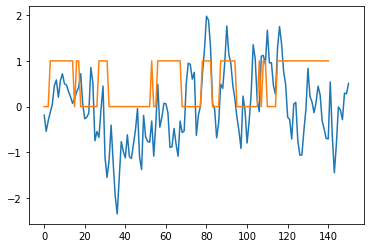

In [38]:
plt.plot(p_data[0,:,10,10])
plt.plot(g_st[0,10:])

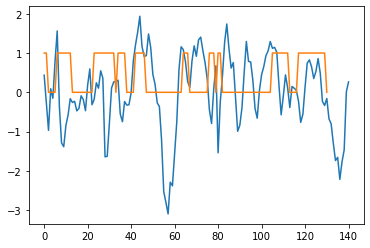

In [42]:
plt.plot(g_data[0,10:,10,10])
plt.plot(e_st[0,20:])

In [ ]:
#plt.plot(anom_t[0,14:])
plt.plot(med_t[0,10:])

In [17]:
##flatten
te1 = med_t
te2 = med_g

te1 = np.reshape(med_t, (9513))
e_st = np.empty((9513))

te2 = np.reshape(med_g, (9513))
g_st = np.empty((9513))



In [18]:
##for checking equal # of pos and negative events
pos = []
neg = []
for i in range(0,9513):
        if te1[i] > 0:
            e_st[i] = 1
            pos.append(1)
            
        elif te1[i] < 0:
            #print("negative")
            e_st[i] = 0
            neg.append(0)
            
        elif te1[i] == 0:
            if len(pos) <= len(neg):
                e_st[i] = 1
                pos.append(1)
            else:
                e_st[i] = 0
                neg.append(0)

##for checking equal # of pos and negative events
pos = []
neg = []
for i in range(0,9513):
        if te2[i] > 0:
            g_st[i] = 1
            pos.append(1)
            
        elif te2[i] < 0:
            #print("negative")
            g_st[i] = 0
            neg.append(0)
            
        elif te2[i] == 0:
            if len(pos) <= len(neg):
                g_st[i] = 1
                pos.append(1)
            else:
                g_st[i] = 0
                neg.append(0)

In [45]:
e_st

array([[1., 1., 1., ..., 1., 1., 0.],
       [0., 0., 0., ..., 0., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       ...,
       [0., 0., 1., ..., 0., 0., 0.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 0., 0., 1.]])

In [20]:
len(pos)

4756

In [21]:
e_st = e_st.reshape((63,151))
g_st = g_st.reshape((63,151))

In [43]:
pickle.dump(e_st, open("1203_classmedian_t.p", 'wb'))
pickle.dump(g_st, open("1203_classmedian_g.p", 'wb'))

pickle.dump(p_data, open("1203_pv.p", 'wb'))
pickle.dump(g_data, open("1203_g.p", 'wb'))